In [318]:
import pymysql
import sqlalchemy
import decouple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [1]:
symbols = ['SPY', 'USO', 'UNG', 'GLD',
           'SLV', 'QQQ', 'IWM', 'MCHI',
           'EWJ', 'VWO', 'VGK', 'EQR',
           'VIXM']



In [319]:
# extract data from AWS
config = decouple.AutoConfig(' ')

user = config('AWS_MY_DB_ADMIN_USER')
host = config('AWS_MY_DB_ADMIN_HOST')
dbname = config('AWS_MY_DB_ADMIN_DBNAME')
pw = config('AWS_MY_DB_ADMIN_PW')
port = int(config('AWS_MY_DB_ADMIN_PORT'))

con = pymysql.connect(host=host,
                      user=user, 
                      database=dbname,
                      password=pw,
                      port=port
                     )

df_list = []

for symbol in symbols:
    qstr = "SELECT * from {}".format(symbol)
    df = pd.read_sql(qstr, con, index_col='date')
    df.index = pd.to_datetime(df.index, format='%Y%m%d')
    df = df.sort_index(ascending=False)
    df_list.append(df)
    df['ticker'] = symbol


cur = con.cursor()


con.close()


In [168]:
for df in df_list:    
    df['lag']  = df['adjclose'].shift(-1)
    df['return'] = (df['adjclose'] - df['lag']) / df['adjclose']
    df['norm_adjclose'] = df['adjclose']/ df['adjclose'][-1] * 100
    df['norm_adjopen'] = df['open'] / df['close'] * df['adjclose'] / df['adjclose'][-1] * 100
    df['norm_adjhigh'] = df['high'] / df['close'] * df['adjclose'] / df['adjclose'][-1] * 100
    df['norm_adjlow'] = df['low'] / df['close'] * df['adjclose'] / df['adjclose'][-1] * 100
    df['volume_dollars_MM'] = (df['volume'] * ((df['low'] + df['high']) / 2) / 1000000).round(4)
    df['return_next'] = df['return'].shift(1)
    

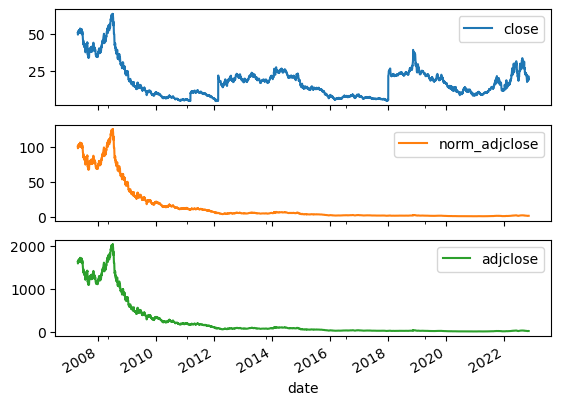

In [169]:
df_list[2].plot(y=['close', 'norm_adjclose', 'adjclose'], subplots=True)
plt.show()

In [ ]:
# dataclean to do:
# 1) plot each time series (adj close)
# 2) check for missing data 
# 2a) check for missing  values in each df DONE-no missing
# 2b) check for missing dates in each df DONE-no missing indices
# 3) normalize high/low/volume for adj close and to $100 starting price
# 3a) change volume to $ volume
# 4) concatenate dfs
# 5) normalize all values to same starting point
# training want 8-10 years w/ (2-4)-1-1 split to start 
# MCHI has least data...could easily drop this
# vix has second least data and also could be dropped
# QQQ/EWJ/EQR indeces 5/8/11 has largest set at 5796 all have matching indices...good sign

In [170]:
# check for missing indices
def  compare_index(df1, df2):
    if len(df1.index) >= len(df2.index):
        ind =  df2.index[-1]
        df = df1[df1.index >= ind]
       
    else:
        ind = df1.index[-1]
        df = df2[df2.index >= ind]
        
    if df2.index.equals(df.index):
        return True
    else:
        return False

unmatched = []
for df in df_list:
    if compare_index(df_list[5], df) == False:
        unmatched.append(df)

for df in unmatched:
    print(df['ticker'][0])

In [317]:
# create two combined datasets, 1 with all columns, 1 with normalized and write to file

def concat_save_data(dfs, write_files=True):
    data_set_full = pd.DataFrame()
    data_set_model = pd.DataFrame()
    
    for df in dfs:
            df = df.add_suffix("_" + df['ticker'][0])
            data_set_full = data_set_full.join(df,
                                               how='outer').sort_index(ascending=False)
    
    df_model = []
    i = 0      
    for n in range(len(dfs)):
        df_model.append(data_set_full.iloc[:, (10+i):(17+i)])
        
        i += 17
    
    for df in df_model:
        if len(data_set_model) ==0:
            data_set_model = df
        else:
            data_set_model = data_set_model.join(df).sort_index(ascending=False)
    
    if write_files==True:
        path = config('PATH_MY_MAIN_DATA')
        data_set_full.to_csv(path_or_buf=path+'/_data_set_full')
        data_set_model.to_csv(path_or_buf=path+'/_data_set_model')

            
    return data_set_full, data_set_model
            
data_full, data_model = concat_save_data(df_list)

